# Yu-Gi-Oh Fall Tournament Data Analysis 
By: Jacob Powell, Date: December 5th, 2018

For this project we will be looking through some information on a local card shops Yu-Gi-Oh Tournaments. This data has been collected from the tournament managers and has been allowed to be used for this project. 

In this project we will be looking to find the outlier deck among the data given. While yet trying to decipher the information trying to find the deck that seems to be causing the most problems among the local tournaments.

In [18]:
import pandas
import matplotlib
import numpy
import matplotlib.pyplot

For this we will first start out at looking at our information from the excel sheet given and try to decipher the information. Once done we will try and form some way to determine a better measurement to help calculate outliers later on in this project.

In [19]:
table = pandas.read_excel('FNG_Fall_Deck_Data.xlsx')

After looking at the data I decided to compute the PPE or Point Per Entry Average so as to help in assisting with figuring the normality later on.

In [36]:
table.Points = table.Points/3
PPE = []
for x in range(len(table)):
    PPE.append(table.Points[x]/table.Entries[x])
table['PPE'] = PPE

Once done calculating the PPE I decided to calculate the normality so as to be able to use that information for a data matrix. This data matrix will help us determine the distances from each point and will allow us to see all potential possibilities in combination. However we must first determine the quantifiable factors for the data to be used to determine the normality.

In [22]:
quant = table.iloc[:, 1:]
norm = (quant - quant.mean())/quant.std()

However before moving forward into making the matrix. I have to make a basic function that will help calculate the distance between two points. Once done I can form the matrix so as to help assist in showing the distances between the two points using eulicidean distance.

In [23]:
#Creating a Distance function:
def dist(i,j):     # The Function that works with finding the distance between i and j
    quant = table.iloc[:, 1:] #the quantitative cells
    cat = table.iloc[:, :0]   #the categorical cells
    norm = (quant - quant.mean())/quant.std() #normalized cells for the quant cells
    hdistance = (cat.iloc[i] != cat.iloc[j]).sum()
    
    qdistance = ((norm.iloc[i] - norm.iloc[j]).abs()).sum()
    return hdistance + qdistance

In [24]:
matrix = pandas.DataFrame(index = table.index, columns = table.index, dtype = float)
for i in range(len(matrix.index)):
    for j in range(i):
        matrix.iloc[i,j] = dist(i,j)
        matrix.iloc[j,i] = dist(j,i)
# matrix

Now that the matrix is made we have to move on to deciphering this information and try to see what deck might be an outlier among the data. Once identified we can test it against the centroids and if it is higher or is the centroid of the highest group we can see that it would be a problematic deck for others to face at local tournaments.

# Deciphering the Data Matrix

With the information from the matrix we will be trying to calculate outliers among the groups and form a basic heatmap and a hexbin heatmap, a heatmap that uses hexagonal shapes instead of breaking it into small sections of squares. With the use of these heatmaps we will be able to see the distinguishable factors among decks and their distances from one another due to their colorations.

Yet when using the hexbin heatmap, we will be able to use it to see if the data follows any form of potential linearity. However when identifying the outliers, we can possibly remove them so as to help with the normality of the information.

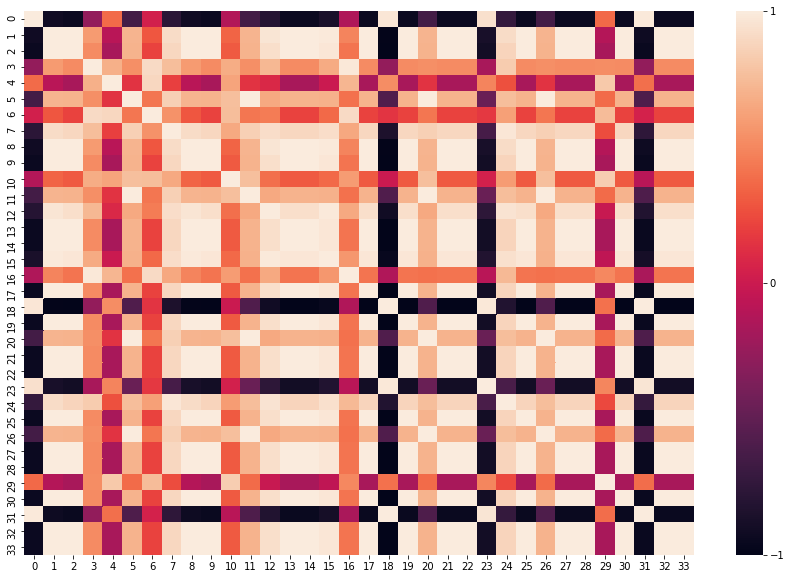

In [25]:
import seaborn
correlation = matrix.corr()
matplotlib.pyplot.figure(figsize = (15,10))
label_ticks = range(-1, 2)
correlmap = seaborn.heatmap(correlation, vmin = -1, vmax = 1, xticklabels=correlation.index, yticklabels=correlation.index, cbar_kws={'ticks': label_ticks})
correlmap

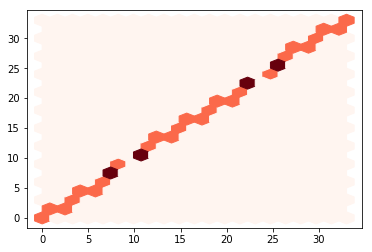

In [26]:
matplotlib.pyplot.hexbin(correlation.index, correlation.index, cmap = matplotlib.pyplot.cm.Reds, gridsize= 20)

As you can see from our data above, shown by the heatmap and the hexbin heatmap our data has some varying changes in distance from one another while also following a basic linear form. However what does this mean for the actual data?

The data now can help us show the form of linearity and some potential outliers among them: Danger Darkworld, Gouki Knightmare, Pendulum Magician, and Nekroz. With this list of potential outliers we can compare it to others verified by a basic scatter plot of normality and compare those points to a basic line of regression.

So let us see if this information follows any form of normality in a normal probability plot. If it doesn't follow the line of regression we might have to reform our idea, and start again.

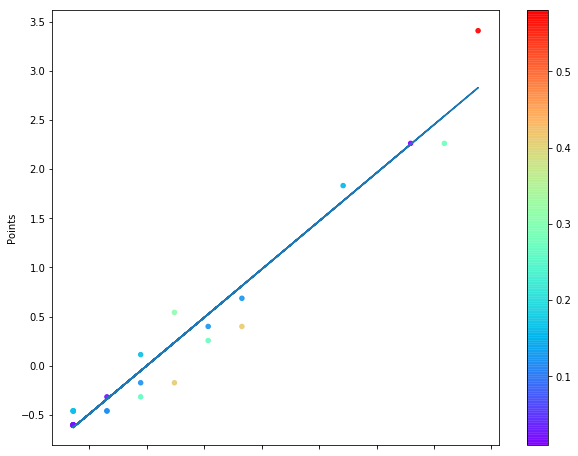

In [27]:
reg_param1 = numpy.polyfit(norm.Entries, norm.Points, 1)
slope1 = reg_param1[0]
intercept1 = reg_param1[1]
estimate1 = slope1*norm.Entries + intercept1
Error1 = norm.Points - estimate1

scatter2 = norm.plot.scatter(x = 'Entries', y = 'Points', c = abs(Error1),figsize = (10,8), cmap = matplotlib.pyplot.cm.rainbow, alpha = 0.9)
scatter2.add_line(matplotlib.lines.Line2D(norm.Entries, estimate1))

As we can see from the data most of the data entries follow the normality of the data, aside from one which seems to be an outlier. Mekk-Knight Invoked seems to be an outlier, however why is this?

This may be due to several different factors, such as falsified information, deck builds, the possibility of merging two or more decks, etc. However it does seem extremely weird that this deck is this far away that it is registering in a different color spectrum than the rest of the decks.

Side note: When the coloration of the dot becomes closer and closer to red, it means it is farther from the line of normality.

In [28]:
import sklearn.cluster
import sklearn.manifold
import nose.tools

Next we will try to form the clusters and figure out if there is anything that would be abnormal aside from our potential list of outliers. If a potential outlier is within its own group and is farther away from the other groups this will guarantee the hypothesis that it is the most problematic deck due to its strength, recovery, or general resourcefulness due to potential power creep.

In [29]:
km = sklearn.cluster.KMeans(n_clusters = 5)
labels = km.fit_predict(norm)
new_table = table.copy()
new_table['Cluster'] = labels
new_table = new_table.sort_values(by = 'Cluster', ascending = True)

In [32]:
mdsinits = norm.loc[:, ['Entries', 'Points']]
ms = sklearn.manifold.MDS(n_components = 2, dissimilarity = 'euclidean', \
                         eps = 0, max_iter = 1000, n_init = 1)
#---------------------------------------------------------------------------
red_data = pandas.DataFrame(ms.fit_transform(norm, mdsinits), columns = ['X', 'Y'])
dist_table = pandas.DataFrame(columns = ['Name', 'X', 'Y'])
dist_table.Name = table.Name
dist_table.X = red_data.X
dist_table.Y = red_data.Y
new_table['X'] = abs(red_data.X)
new_table['Y'] = abs(red_data.Y)

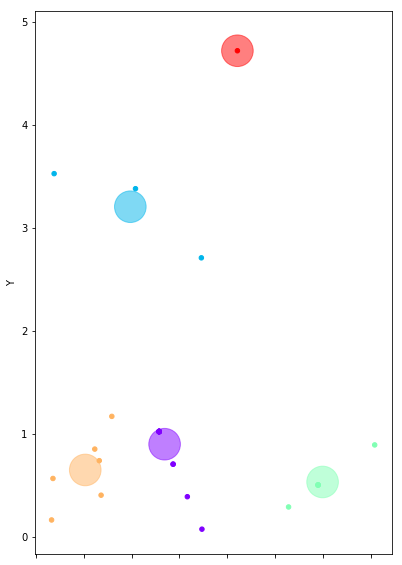

In [34]:
plot = new_table.plot.scatter(c= 'Cluster', x = 'X', y = 'Y', cmap = matplotlib.pyplot.cm.rainbow, figsize = (10,10))
groups = new_table.groupby('Cluster')
centroid = groups.mean()
centroid.plot.scatter(c = centroid.index, x = 'X', y = 'Y', cmap = matplotlib.cm.rainbow, s = 1000, ax = plot, alpha = .5)
plot.figure.axes[1].remove()
plot.figure.axes[1].remove()

In [35]:
newCentTab = pandas.DataFrame(centroid.X, columns = ['X', 'Y'])
newCentTab.Y = centroid.Y
newCentTab

,X,Y
Cluster,,
0,0.672805,0.903930
1,0.493840,3.207835
2,1.497753,0.537653
3,0.258460,0.654153
4,1.052966,4.721010


As we can see from the data that each data point is part of its own group of data entries and is near a separate centroid. However Mekk-Knight Invoked seems to be the only one far enough away from the other points for it to be considered that it would have to be within its own group. Due to this it is the centroid of that singular group and it only further proves that Mekk-Knight Invoked is more powerful than any other deck currently in the locals.

# Conclusion

Due to the data as shown above, we see that Mekk-Knight Invoked seems to be the one deck that is the most problematic in strength and resourcefulness. This is due to the fact of it straying so far away from the path of normality and it forcing itself to be part of its very own group. Due to this information, there are a few things in which we could do to limit its power. For one if it is running another strong draw power engine such as the Sky Striker engine we could remove it which might lower its recovery factor enough to where it could compete with other decks on a fair level. Another option is that the player might be cheating or abusing ceratin aspects of the game and cards so as to make them seem like they are the best player. Then finally it might be due to the fact that it is one of the newer decks and has a greater power creep than the rest, allowing it to out perform the older decks. It also has the capability to be merged with other deck engines to allow it to perform at a higher rate than it could alone.

So overall Mekk-Knight Invoked is the problematic deck among the local tournament and the local meta. 